In [1]:
from src.brains import Net
from src.entities import Creature, Food
from src.gen_algo import crossover
from src.stages import (
    get_creatures_closets_food,
    move_creatures,
    creatures_actions,
    update_creatures,
    )
from src.utils import get_run_df, plot_state

import itertools
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
num_creatures = 300
winners_to_select = 55
num_randoms = 55
num_parents = 20
num_iteration = 1000
num_food = 50
x_width = 512
y_width = 512
additional_foods = 5

In [3]:
foods = {i: Food(i, x_width, y_width) for i in range(num_food)}

creatures = [
	Creature(Net(), x_width, y_width) for i in range(num_creatures)
]

In [4]:
def get_nex_generation(creatures, num_parents=num_parents, num_winners=winners_to_select, num_randoms=num_randoms):
	df = get_run_df(creatures)
	parents = df['neural_network'].values[:num_parents]
	combinations = list(itertools.combinations(parents, 2))
	winners =  df['neural_network'].values[:num_winners].tolist()
	winners = [Creature(Net(x.get_weights()), x_width, y_width) for x in winners]

	creatures = []
	for nn1, nn2 in combinations:
		new_params = crossover(nn1,nn2)
		creatures.append(Creature(Net(new_params), x_width, y_width))
	creatures = creatures + winners
	creatures = creatures + [Creature(Net(), x_width, y_width) for i in range(num_randoms)]
	return creatures

In [5]:
def perform_one_iteration(creatures, foods,additional_foods=additional_foods, num_food=num_food):
	if len(foods) <= num_food/2:
		if foods=={}:
			max_food_key = 0
		else:
			max_food_key = max(list(foods.keys()))
		foods.update({max_food_key + i: Food(max_food_key + i, x_width, y_width) for i in range(additional_foods)})
	creatures = get_creatures_closets_food(creatures, foods, x_width, y_width)
	creatures = update_creatures(creatures, foods)
	creatures = move_creatures(creatures, x_width, y_width)
	creatures = creatures_actions(creatures, foods)
	return creatures, foods

In [6]:
def run_generation(creatures, foods, num_iteration=num_iteration, show_plots=False):
	all_alive = True
	iter = 0
	while all_alive:
		creatures, foods = perform_one_iteration(creatures, foods)
		all_alive = np.any([creature.energy > 0 for creature in creatures])
		iter += 1
		if iter > num_iteration:
			break
		if show_plots:
			plot_state(creatures, foods,x_width, y_width)
	return creatures

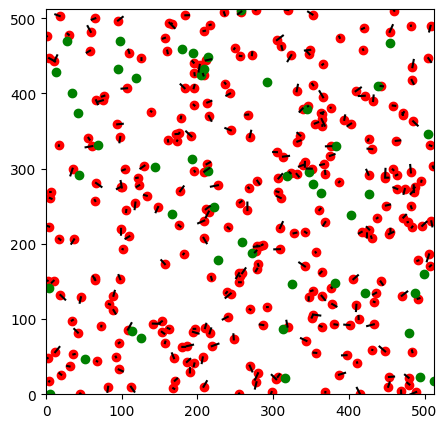

In [7]:
plot_state(creatures, foods, x_width, y_width)

In [8]:
num_gens = 100
means = []
std = []
for j in range(num_gens):
	foods = {i: Food(i, x_width, y_width) for i in range(num_food)}
	creatures = run_generation(creatures, foods, num_iteration=num_iteration)
	df = get_run_df(creatures)
	means.append(df['score'].mean())
	if j%10 == 0:
		print(f'{j} - {len(creatures)} - {df["score"].min()}, {df["score"].mean().round(2)}, {df["score"].quantile(0.8).round(2)}, {df["score"].max()}')
	if j != num_gens - 1:
		creatures = get_nex_generation(creatures)
print(f'{j} - {len(creatures)} - {df["score"].min()}, {df["score"].mean().round(2)}, {df["score"].quantile().round(2)}, {df["score"].max()}')

0 - 300 - 49, 59.3, 79.0, 169
10 - 300 - 49, 59.0, 79.0, 199
20 - 300 - 49, 180.95, 169.0, 1001
30 - 300 - 49, 210.71, 199.0, 1001
40 - 300 - 49, 204.39, 199.0, 1001
50 - 300 - 49, 182.98, 169.0, 1001
60 - 300 - 49, 205.71, 229.0, 1001
70 - 300 - 49, 205.31, 175.0, 1001
80 - 300 - 49, 223.03, 229.0, 1001
90 - 300 - 49, 220.5, 175.0, 1001
99 - 300 - 49, 233.74, 49.0, 1001


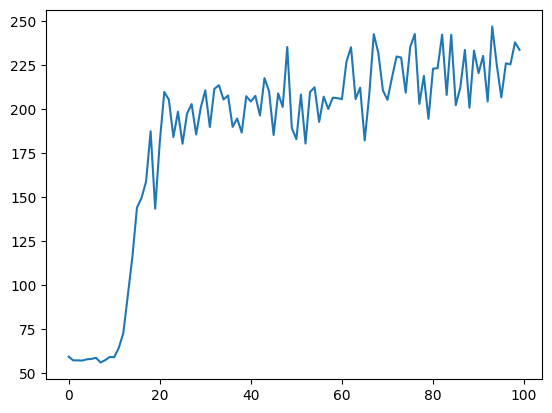

In [9]:
plt.plot(
	np.arange(0,len(means),1),
 means
)

In [10]:
df = pd.DataFrame([{'nn':creature.neural_network,'score':creature.score} for creature in creatures])
df = df.sort_values(by='score', ascending=False)

In [11]:
idx = df.head().index

In [12]:
creatures = [
    creatures[i] for i in idx  
    ]

In [13]:
for i in range(len(creatures)):
	creatures[i].energy = 200
	creatures[i].x = random.randint(0,x_width)
	creatures[i].y = random.randint(0,y_width)

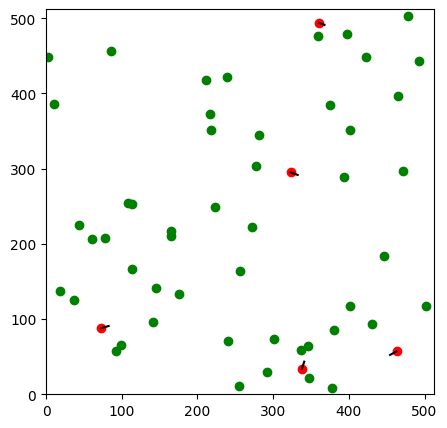

In [14]:
foods = {i: Food(i, x_width, y_width) for i in range(num_food)}

plot_state(creatures, foods, x_width, y_width)

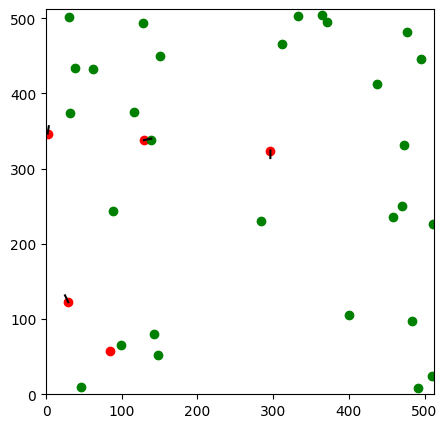

In [15]:
run_generation(creatures, foods, num_iteration=500, show_plots=True)